In [17]:
import pandas as pd
import nltk
import numpy as np
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
from nltk.tokenize import sent_tokenize

# Load data
url = 'https://raw.githubusercontent.com/DyanelLancea/Airline-Review-Sentiement-Analysis/refs/heads/master/airlines_review.csv'
df = pd.read_csv(url)

# List of special characters to remove
removechar = [ '@', '#', '$', '%', '^', '&', '*', '(', ')',
               '-', '_', '=', '+', '{', '}', '[', ']', '|',
               '\\', ':', ';', '"', "'", '<', '>', '?',
                 '/', '~', '`', '✅ Trip Verified', 'Not Verified', 'Â Â', '✅ Verified Review']

# Remove duplicates
df = df.drop_duplicates()
# Remove rows with missing values
df = df.dropna()

# Replace missing values with NA or Unknown function
def replace_missing_value(df):
    for col in df.columns:
        if df[col].dtype == 'O':  # Object type (string)
            df[col] = df[col].fillna('Unknown')
        else:
            df[col] = df[col].fillna("NA")
    return 

# Remove special characters from specific columns function
def remove_special_characters(df, removechar, char):
    for char in removechar:
        df['Airlines'] = df['Airlines'].str.replace(char, ' ', regex=False)
        df['Text Content'] = df['Text Content'].str.replace(char, '', regex=False)
    return df

# Apply data cleaning functions
replace_missing_value(df)
remove_special_characters(df, removechar, char='')

# Standardize text case
df['Airlines'] = df['Airlines'].str.title()
df['Name'] = df['Name'].str.title()
df['Text Content Lower Case'] = df['Text Content'].str.lower()

# Remove leading spaces from the 'Name' column
df['Airlines'] = df['Airlines'].str.lstrip()
df['Name'] = df['Name'].str.lstrip()
df['Date Published'] = df['Date Published'].str.lstrip()
df['Text Content'] = df['Text Content'].str.lstrip()



# Save cleaned data to a new CSV file
df.to_csv('airlines_review_cleaned.csv', index=False)

# Display the cleaned DataFrame
#print(df)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\daryl\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Function to read and parse the AFINN lexicon, then loads it into a dictionary (afinn_dict)

In [18]:
import requests

def load_afinn_lexicon(afinn_url):
    afinn_dict = {} # initialise an empty dictionary to hold the AFINN lexicon
    response = requests.get(afinn_url)  # download the file
    try:
        for line in response.text.splitlines():
            line = line.strip()
            if not line: # checks for and skips any empty lines in the file
                continue
            word, score = line.rsplit('\t', 1) # splits the line into two parts
            afinn_dict[word] = int(score) # adds the word and its score to the dict
    except FileNotFoundError:
        print(f"File not found: {afinn_url}")
    return afinn_dict


### Load the AFINN lexicon (provided sentiment dictionary) then print a sample of it

In [19]:
afinn_url = "https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt"
afinn_dict = load_afinn_lexicon(afinn_url)

print("AFINN dictionary loaded. Sample entries:")
print(list(afinn_dict.items())[:10])  # show first 10 words and scores


AFINN dictionary loaded. Sample entries:
[('abandon', -2), ('abandoned', -2), ('abandons', -2), ('abducted', -2), ('abduction', -2), ('abductions', -2), ('abhor', -3), ('abhorred', -3), ('abhorrent', -3), ('abhors', -3)]


### Function for sentence tokanization 
This function takes some text and returns a list of sentences. If you don’t give it a string, it safely returns an empty list instead of crashing.

In [20]:
def tokenize_sentences(text):
    if not isinstance(text, str):
        return []
    return sent_tokenize(text)

### Function to calculate sentiment and normalization

In [21]:
def calculate_sentiment_score(sentences, afinn_dict):
    score = 0
    words = sentences.lower().split()    # breaks down the sentence into individual words
    for word in words:  # goes through each word in the list 
        score += afinn_dict.get(word, 0)    # looks up each word and adds the score
    return score

def normalize_score(score, text_length):
    if text_length == 0:    # sentences with no words will return a score of 0 (preventing an error of dividing by zero)
        return 0
    # normalization to get a score per word, then clamping to [-1, 1]
    normalized = score / text_length    # calculates the average score per word
    return max(-1.0, min(1.0, normalized))  
    # makes sure the score doesn't go over 1.0 and below -1.0. 
    # (if the score is -2.5, this will return -1.0)

### Function to find the extreme sentences

In [22]:
def find_extreme_sentences(sentences, afinn_dict):
    
    if not sentences:   # to prevent errors if the list is empty
        return None, None

    # initialises an empty list to hold sentences and their scores
    scored_sentences = []
    for sent in sentences:
        score = calculate_sentiment_score(sent, afinn_dict)     # uses the sentiment score function
        normalized_score = normalize_score(score, len(sent.split()))    # uses the normalization function
        scored_sentences.append({'sentence': sent, 'score': normalized_score})

    # find the sentences with max and min normalized scores
    most_positive = max(scored_sentences, key=lambda x: x['score'])
    most_negative = min(scored_sentences, key=lambda x: x['score'])
    
    return most_positive, most_negative

### Sliding Window Function to find the most positive and negative paragraphs.

Using a window size lets us "slide" a focus area over the text. The window's score changes as it moves, so it can detect specific pockets of strong emotion(positive/negative).

When the window is over a section with very positive sentences, it will get a high score. When it slides over the negative section, it will get a very low score.

This give us a much more detailed and accurate picture of the sentiment throughout the text. It helps us pinpoint exactly where the most positive and negative opinions are located, rather than just getting a single, overall average.

In [23]:
def sliding_window_analysis_words(text, afinn_dict, window_size=10):
    """
    Applies a sliding window to find the most positive and negative text segments,
    based on a word-level window size.
    
    Args:
        text (str): The full text to analyze.
        afinn_dict (dict): The AFINN sentiment lexicon.
        window_size (int): The number of words to include in each window.

    Returns:
        tuple: A tuple containing the most positive and most negative paragraphs.
    """
    if not text:
        return None, None
        
    words = text.lower().split()
    if len(words) < window_size:
        return None, None
    
    scored_windows = []
    # Slide the window across the words
    for i in range(len(words) - window_size + 1):
        window = words[i:i + window_size]
        paragraph_text = ' '.join(window)
        
        # Calculate score for the paragraph window
        score = calculate_sentiment_score(paragraph_text, afinn_dict)
        normalized_score = normalize_score(score, len(paragraph_text.split()))

        scored_windows.append({'paragraph': paragraph_text, 'score': normalized_score})

    if not scored_windows:
        return None, None

    # Find the paragraphs with max and min scores
    most_positive_paragraph = max(scored_windows, key=lambda x: x['score'])
    most_negative_paragraph = min(scored_windows, key=lambda x: x['score'])
    
    return most_positive_paragraph, most_negative_paragraph



Test

In [24]:
#Apply tonkenize function into Dataframe
df['Text Content Tokenized'] = df['Text Content'].apply(tokenize_sentences)

#Apply Sentiment scoring function into Dataframe
df['Sentiment Score'] = df.apply(lambda x: calculate_sentiment_score(x['Text Content'],afinn_dict), axis=1)

#Apply normalize function to Dataframe
df['Normalized Sentiment Score'] = df.apply(lambda x: normalize_score(x['Sentiment Score'],len(x["Text Content"].split())), axis=1)

#Apply finding extreme sentences function to Dataframe
df['Extreme Senctences'] = df.apply(lambda x: find_extreme_sentences(x['Text Content Tokenized'],afinn_dict), axis=1)

#Creating Columns for Most and Least Extreme Sentences
df['Most Positive Senctence'] = df['Extreme Senctences'].apply(lambda x: x[0]['sentence'])
df['Most Positive Senctence Score'] = df['Extreme Senctences'].apply(lambda x: x[0]['score'])
df['Most Negative Senctence'] = df['Extreme Senctences'].apply(lambda x: x[1]['sentence'])
df['Most Negative Senctence Score'] = df['Extreme Senctences'].apply(lambda x: x[1]['score'])

#Applying Sliding Window to Dataframe
df['Sliding Window Results'] = df.apply(lambda x: sliding_window_analysis_words(x['Text Content'],afinn_dict, window_size=10), axis=1)

#Creating Columns for Most Positive and Negative lines of words from sliding window analysis
df['Most Positive Line'] = df['Sliding Window Results'].apply(lambda x: x[0]['paragraph'])
df['Most Positive Line Score'] = df['Sliding Window Results'].apply(lambda x: x[0]['score'])
df['Most Negative Line'] = df['Sliding Window Results'].apply(lambda x: x[1]['paragraph'])
df['Most Negative Line Score'] = df['Sliding Window Results'].apply(lambda x: x[1]['score'])

#Output results into csv
df.to_csv('airlines_review_analysis.csv', index=False)


### Results



#### Model Evaulation

We shall be evaluating our sentiment analysis based on 4 metrics Accuracy, Precision, Recall and F1 Score.

In [60]:
#Function to convert our analysis scores from numbers to postive or negative
def score_postive_negative(score):
    if score < -0:
        return "Negative"
    elif score >= 0:
        return "Postive"
    
#Function to chnage airline review ratings to postive or negative
def rating_postive_negative(rating):
    if rating <= 5:
        return "Negative"
    elif rating >= 6:
        return "Postive"

#Funtion to check if your analysis is True or False 
def determine_correct_prediction(actual, pred):
    if actual == pred:
        return True
    else:
        return False
    
#Function to calculate accuracy
def calculate_aaccuracy(whether_correct_pred):
    return sum(whether_correct_pred)/len(whether_correct_pred)

#Funtion to calculate confusion matrix
def calculate_confusion_matrix(actual, pred):
    if actual == 'Postive' and pred == 'Postive':
        return 'TP'
    elif actual == 'Negative' and pred == 'Postive':
        return 'FP'
    elif actual == 'Negative' and pred == 'Negative':
        return 'TN'
    elif actual == 'Postive' and pred == 'Negative':
        return 'FN'

#Function to calculate precision
def calculate_precision(confusion_matric):
    return confusion_matric.count('TP')/(confusion_matric.count('TP')+confusion_matric.count('FP'))

#Funtion to calculate Recall
def calculate_recall(confusion_matric):
    return confusion_matric.count('TP')/(confusion_matric.count('TP')+confusion_matric.count('FN'))

#Applying the all the functions to our datafraame
df['score_postive_negative'] = df.apply(lambda x: score_postive_negative(x['Normalized Sentiment Score']), axis=1)
df['rating_postive_negative'] = df.apply(lambda x: rating_postive_negative(x['Rating']), axis=1)
df['whether_correct_pred'] = df.apply(lambda x: determine_correct_prediction(x['rating_postive_negative'],x["score_postive_negative"]), axis=1)
df['confusion_matrix'] = df.apply(lambda x: calculate_confusion_matrix(x['rating_postive_negative'],x["score_postive_negative"]), axis=1)
recall = calculate_recall(df['confusion_matrix'].tolist())
precision = calculate_precision(df['confusion_matrix'].tolist())

#Funtion to Calculate F1 Score
def calculate_F1score(precision,recall):
    return 2 * (precision * recall) / (precision + recall)

#Print out the results
print('Accuracy of Sentiment Analysis is',calculate_aaccuracy(df['whether_correct_pred']))
print(f'Precision of Sentiment Analysis is {precision}')
print(f'Recall of Sentiment Analysis is {recall}')
print('F1 Score of Sentiment Analysis is',calculate_F1score(precision,recall))

Accuracy of Sentiment Analysis is 0.8044812133746984
Precision of Sentiment Analysis is 0.7771851851851852
Recall of Sentiment Analysis is 0.9313528228192686
F1 Score of Sentiment Analysis is 0.8473134489070744


Usually, sentiment classification of accuracy between 80 to 85% is a good benchmark. Therefore, we can say our analysis just about hits thaat mark at 80.4%. However, accuracy may not be the most aaccurate metric to test our analysis as it can be misledding for uneven datasets.

With a precision of 77.7%, the model correctly identified most of the reviews it labeled as positive. However, this also indicates that a small proportion of negative reviews were incorrectly predicted as positive which may be lead to some airlines getting better reviews than expected.

The recall score of 93.1% demonstrates that the model successfully identified the vast majority of actual positive reviews and would allow us to tell if the airline is truly good based on the reviews.

The F1 score of 84.7% provides a balanced measure of performance, reflecting the model’s ability to maintain both high recall and reasonable precision.


### Insights into our results

This calculates the mean normalized sentiment score for each airline and visualizes the results using a horizontal bar chart.

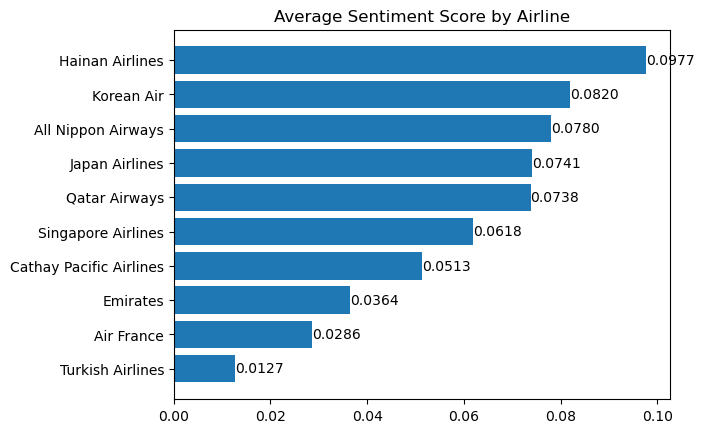

In [27]:
import matplotlib.pyplot as plt
df_mean =  df.groupby('Airlines')['Normalized Sentiment Score'].agg('mean').sort_values() 

fig, ax = plt.subplots()

bx = ax.barh(df_mean.index, df_mean.values,label=df_mean.values)
ax.bar_label(bx, fmt='%.4f')
ax.set_title('Average Sentiment Score by Airline')

plt.show()

This generates a boxplot to compare the spread and distribution of normalized sentiment scores across different airlines.

Text(0.5, 1.0, 'Boxplot of Sentment Scores by Airline')

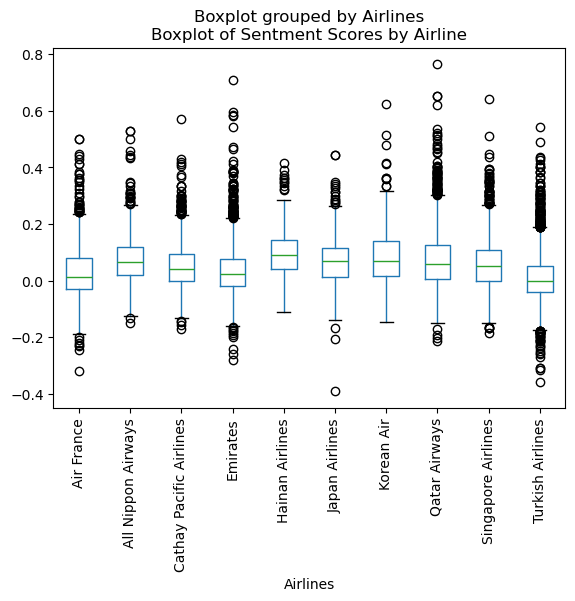

In [28]:
ax = df.boxplot(column='Normalized Sentiment Score',by='Airlines',rot=90,grid=False)
ax.set_title('Boxplot of Sentment Scores by Airline')

In [29]:
from flask import Flask, render_template_string, request
import pandas as pd
import requests
from io import StringIO
nltk.download('punkt_tab')

app = Flask(__name__)

# URL of the CSV file
#url = 'https://raw.githubusercontent.com/DyanelLancea/Airline-Review-Sentiement-Analysis/refs/heads/master/airlines_review.csv'

# Fetch and load the CSV data
response = requests.get(url)
csv_data = StringIO(response.text)
#df = pd.read_csv(csv_data)

from nltk.tokenize import sent_tokenize

# Apply AFINN sentiment analysis
df["sentiment_score"] = df["Text Content Lower Case"].apply(
    lambda x: normalize_score(
        calculate_sentiment_score(str(x), afinn_dict),
        len(str(x).split())
    )
)

# Convert 'Date' column to datetime to facilitate month selection
df['Date Published'] = pd.to_datetime(df['Date Published'])

# Extract available airlines and months for the dropdowns
airlines = df['Airlines'].unique().tolist()
months = df['Date Published'].dt.month_name().unique().tolist()


@app.route('/', methods=['GET', 'POST'])
def index():
    selected_airline = None
    selected_month = None
    t_reviews = []
    b_reviews = []
    positive_window = None
    negative_window = None

    if request.method == 'POST':
        selected_airline = request.form.get('airline')
        selected_month = request.form.get('month')

        if selected_airline and selected_month:
            # Filter reviews based on selected airline and month
            filtered_df = df[(df['Airlines'] == selected_airline) &
                             (df['Date Published'].dt.month_name() == selected_month)]
        
            # Sort the filtered DataFrame by 'Normalized Sentiment Score' in descending order
            top_reviews_df = filtered_df.sort_values(by='Sentiment Score', ascending=False)
            bottom_reviews_df = filtered_df.sort_values(by='Sentiment Score', ascending = False)

            # Select the top 3 reviews based on the highest sentiment score
            top_reviews = top_reviews_df.head(3)
            bottom_reviews = bottom_reviews_df.tail(3)

            # Store the reviews with the highest sentiment scores
            t_reviews = top_reviews[['Text Content', 'Sentiment Score']].values.tolist()
            b_reviews = bottom_reviews[['Text Content', 'Sentiment Score']].values.tolist()

            all_text = ' '.join(filtered_df['Text Content'].dropna().astype(str).tolist())

            pos, neg = sliding_window_analysis_words(all_text, afinn_dict, window_size=10)

            positive_window = pos  # {'paragraph': ..., 'score': ...}
            negative_window = neg

    # HTML template directly in the Python code using render_template_string
    html_content = '''
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>Airline Reviews</title>
            <style>
                .review-list {
                    font-size: 10px;
                    line-height: 1.5;
                    font-family: Arial, sans-serif;
                }

                .review-list li {
                    margin-bottom: 10px;
                }

                .review-header {
                    font-size: 18px;
                    font-weight: bold;
                    margin-bottom: 10px;
                }

                /* Style the sentiment score section */
                .score {
                    color: #007BFF;
                    font-weight: bold;
                }

                /* Add some padding and style for form */
                form {
                    margin-bottom: 20px;
                }

                label {
                    font-weight: bold;
                    margin-right: 10px;
                }

                select, button {
                    margin: 5px 10px;
                }

            </style>
        </head>
        <body>
            <h1>Airline Review Sentiment Analysis</h1>

            <form method="POST">
                <label for="airline">Select Airline:</label>
                <select name="airline" id="airline" required>
                    <option value="">--Select Airline--</option>
                    {% for airline in airlines %}
                        <option value="{{ airline }}" {% if airline == selected_airline %}selected{% endif %}>{{ airline }}</option>
                    {% endfor %}
                </select>

                <label for="month">Select Month:</label>
                <select name="month" id="month" required>
                    <option value="">--Select Month--</option>
                    {% for month in months %}
                        <option value="{{ month }}" {% if month == selected_month %}selected{% endif %}>{{ month }}</option>
                    {% endfor %}
                </select>

                <button type="submit">Filter Reviews</button>
            </form>

            <hr>

            {% if t_reviews %}
                <h2 class="review-header">Top Reviews for {{ selected_airline }} in {{ selected_month }}:</h2>
                <div class="review-list">
                    <ul>
                        {% for t_reviews, score in t_reviews %}
                            <li>
                                <p><strong>Review:</strong> {{ t_reviews }}</p>
                                <p><strong>Score:</strong> <span class="score">{{ score }}</span></p>
                            </li>
                        {% endfor %}
                    </ul>
                </div>
             {% endif %}   
            
             {% if b_reviews %}
                <h2 class="review-header">Lowest Reviews for {{ selected_airline }} in {{ selected_month }}:</h2>
                <div class="review-list">
                    <ul>
                        {% for b_reviews, score in b_reviews %}
                            <li>
                                <p><strong>Review:</strong> {{ b_reviews }}</p>
                                <p><strong>Score:</strong> <span class="score">{{ score }}</span></p>
                            </li>
                        {% endfor %}
                    </ul>
                </div>
            {% endif %}
            {% if not t_reviews and not b_reviews %}
                <p>No reviews found for the selected filters.</p>
            {% endif %}

             {% if positive_window %}
                <h2 class="review-header">Most Positive Text Segment (Sliding Window):</h2>
                <p><strong>Text:</strong> {{ positive_window.paragraph }}</p>
                <p><strong>Score:</strong> <span class="score">{{ positive_window.score }}</span></p>
            {% endif %}

            {% if negative_window %}
                <h2 class="review-header">Most Negative Text Segment (Sliding Window):</h2>
                <p><strong>Text:</strong> {{ negative_window.paragraph }}</p>
                <p><strong>Score:</strong> <span class="score">{{ negative_window.score }}</span></p>
            {% endif %}
        </body>
        </html>
        '''
    
    return render_template_string(html_content, airlines=airlines, months=months, t_reviews=t_reviews, b_reviews=b_reviews, selected_airline=selected_airline, selected_month=selected_month, positive_window=positive_window,
        negative_window=negative_window)

if __name__ == "__main__":
    app.run(debug=True, host='127.0.0.1', port=5002, use_reloader=False)


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\daryl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5002
Press CTRL+C to quit
